In [1]:
# !pip install scipy statsmodels

In [1]:
import numpy as np
import scipy.optimize as opt
import time
import statsmodels.api as sm
import pandas as pd 
import matplotlib.pyplot as plt

---- 

# Replicating Arcidiacono Miller (2011), Table 1 Column (4)

In this case, the time-invariant type (bus model, say) is unobserved and unaccounted for in estimation.

In [2]:
# Parameter values
alpha = np.array([2, -0.15, 1, 0.9, 0.4]) # θ_0, θ_1, θ_2, β, Pr(s = 0)

T = 20    # Time periods
N = 2000  # Number of individuals
burnin = 10

Grids for mileage (time-varying characteristic) and route characteristic (time-invariant).

In [3]:
# mileage 
x1 = np.arange(0, 25.125, 0.125)
x1l = len(x1)
# route char
x2 = np.arange(0.25, 1.26, 0.01)
x2l = len(x2)
# discrete type
x3 = np.arange(0, 2, 1)
x3l = len(x3)

From Equation 7.2 (p. 1852), 
$$
f_2(x_{1, t+1} | x_{t}) = 1\{x_{1, t+1} \geq x_{t}\} [ e^{-x_2(x_{1, t+1} - x_{t})} - e^{-x_2(0.125 + x_{1, t+1} - x_{t})} ]
$$
Note $f_1(x_{1, t+1} | x_{t}) = f_1(x_{1, t+1} | 0)$. Rows are $x_t$ and columns are $x_{t+1}$.

In [4]:
def xgrid(x1, x2, x1l, x2l):
    x1ub = np.concatenate([x1[1:], [np.inf]])
    xtran = np.zeros((x1l * x2l, x1l))  # Placeholder for transition matrix
    xtranc = np.zeros((x1l, x1l, x2l))  # Placeholder for cumulative transition matrix
    xtran_slice = np.zeros((x1l, x1l))
    for j in range(x2l):
        for i in range(x1l):
            xtran_slice[:, i] = (x1[i] >= x1) * ( np.exp(- x2[j] * (x1[i] - x1)) - np.exp(- x2[j] * (x1ub[i] - x1)) )
        xtran[x1l * j : x1l * (j + 1), :] = xtran_slice / xtran_slice.sum(axis = 1, keepdims=True)
        xtranc[:, :, j] = np.clip(np.cumsum(xtran_slice, axis = 1), 0.0, 1.0)
    return xtran, xtranc

xtran, xtranc = xgrid(x1, x2, x1l, x2l)

### Simulate Engine Replacement Data (```genbus4.m```)

$$
u_1(x_{1t}, s) = 0 \quad\quad\quad\quad u_2(x_{1t}, s) = \theta_0 + \theta_1 \min\{x_{1t}, 25\} + \theta_2 s
$$

In this instance there is a difference between correctly specified flow utility (used to simulate the data) and incorrectly specified utility (used in estimation).

In [25]:
def flowpayoff_replace(alpha, x1, x3): 
    return 0.0

def flowpayoff_noreplace(alpha, x1, x3): 
    return alpha[0] + alpha[1] * x1 + alpha[2] * x3

def flowpayoff_replace_wrong(alpha, x1, x3): 
    return 0.0

def flowpayoff_noreplace_wrong(alpha, x1, x3): 
    return alpha[0] + alpha[1] * x1

Define the choice-specific conditional value function, $v_{jt}(z_t)$, as the flow payoff of action $j$ without $\varepsilon_{jt}$ plus the expected future utility conditional on following the optimal decision rule from period t + 1 on:
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} V_{t+1}(z_{t+1}) f_{jt}(z_{t+1} | z_{t})
$$
where $V_{t+1}(z_{t+1}) = \int_{\varepsilon_{t+1}} \max\{v_{1t+1}(z_t+1), v_{2t+1}(z_t+1)\} dF(\varepsilon_{t+1})$. Assuming $\varepsilon_{t+1} \sim EVT1$ i.i.d. across choices and over time, 
$$
V_{t+1}(z_{t+1}) = \int_{\varepsilon_{t+1}} \max\{v_{1t+1}(z_t+1) + \varepsilon_{1t+1}, v_{2t+1}(z_t+1)  + \varepsilon_{2t+1}\} dF(\varepsilon_{t+1}) = \gamma_{Euler} + \ln \bigg( e^{v_{1t+1}(z_t+1)} + e^{v_{2t+1}(z_t+1)} \bigg)
$$
See Equation 2.4 and Equation 14 in [Llull's notes](https://joanllull.github.io/Structural_micro/Structural_micro_3.pdf). 

In [6]:
def conditional_value_function(beta, u_zt, V_ztprime, f_ztprime_zt):
    return u_zt + beta * np.dot(f_ztprime_zt, V_ztprime)

def Emax(v_replace, v_noreplace):
    return np.euler_gamma + np.logaddexp( v_replace, v_noreplace )

Recall $v_{jt}(z_t)$ always takes the standpoint of being at time $t$ _just before_ $\varepsilon$ is realized. 

If you take the renewal action this period, you go back to zero and hence the relevant transition to the future is $f_t(x_{t+1} | 0)$. 

If you do not take the renewal action, the relevant transition depends on your accumulated mileage, $f_t(x_{t+1} | x_t)$.

In [ ]:
def BackwardInduction_V(alpha, x1, x2, x3, x1l, x2l, x3l, TT):
    V = np.zeros((x1l * x2l, 2, TT)) 
    for t in range(TT - 2, -1, -1):
        for x3idx in range(x3l):
            for x2idx in range(x2l):
                for x1idx in range(x1l): # indexing x_{1t} as we enter the period 
                    v_replace   = conditional_value_function(alpha[3], flowpayoff_replace(alpha, x1[x1idx], x3[x3idx]),   V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx, :])
                    v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace(alpha, x1[x1idx], x3[x3idx]), V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx + x1idx, :])
                    V[x1l * x2idx + x1idx, x3[x3idx], t] = Emax(v_replace, v_noreplace)
    return V 

def BackwardInduction_V_wrong(alpha, x1, x2, x3, x1l, x2l, x3l, TT):
    V = np.zeros((x1l * x2l, 2, TT)) 
    for t in range(TT - 2, -1, -1):
        for x3idx in range(x3l):
            for x2idx in range(x2l):
                for x1idx in range(x1l): # indexing x_{1t} as we enter the period 
                    v_replace   = conditional_value_function(alpha[3], flowpayoff_replace_wrong(alpha, x1[x1idx], x3[x3idx]),   V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx, :])
                    v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace_wrong(alpha, x1[x1idx], x3[x3idx]), V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx + x1idx, :])
                    V[x1l * x2idx + x1idx, x3[x3idx], t] = Emax(v_replace, v_noreplace)
    return V 

<BarContainer object of 29 artists>

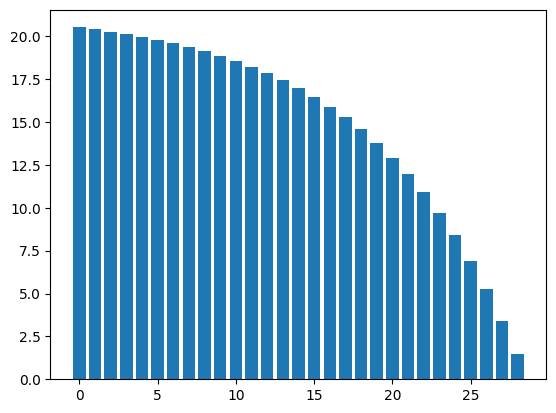

In [8]:
V = BackwardInduction_V(alpha, x1, x2, x3, x1l, x2l, x3l, T + burnin)
plt.bar(np.arange(0, T + burnin - 1), [ np.mean(V[:, 0, x]) for x in np.arange(0, T + burnin - 1) ])

In [9]:
def genbus(alpha, N, T, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l):
    
    V = BackwardInduction_V(alpha, x1, x2, x3, x1l, x2l, x3l, T + burnin)

    x1idx = np.zeros((N, T + burnin)).astype(int)
    x2idx = np.random.randint(0, x2l, N)
    x3idx  = (np.random.rand(N) > alpha[4]).astype(int)   # type
    X1 = np.zeros((N, T + burnin))                        # accumulating mileage. all buses start at zero.  
    X2 = x2[x2idx]                                        # permanent characteristic
    Y = np.zeros((N, T + burnin))
    p_replace = np.zeros((N, T + burnin))
    Draw = np.random.rand(N, T + burnin)
    Draw2 = np.random.rand(N, T + burnin)

    for n in range(N):
        for t in range(T + burnin - 1):
            v_replace   = conditional_value_function(alpha[3], flowpayoff_replace(alpha, X1[n, t], x3idx[n]), V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l, :])
            v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace(alpha, X1[n, t], x3idx[n]), V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l + x1idx[n, t], :])
            p_replace[n, t] = 1 / ( 1 + np.exp(v_noreplace - v_replace) )
            Y[n, t] = Draw[n, t] < p_replace[n, t] # Y = 1 <-> replace.
            x1idx[n, t + 1] = (1 - Y[n, t]) * np.sum((Draw2[n, t] * np.ones(x1l)) > xtranc[x1idx[n, t], :, x2idx[n]]) # if not replace, draw x_{1t+1} from mileage transition; if replace, x_{1t+1} = 0.
            X1[n, t + 1] = x1[x1idx[n, t + 1]]

    # The econometrician is assumed to see only the last T periods. (p.1853)  
    return Y[:, burnin - 1:T + burnin - 1], X1[:, burnin - 1:T + burnin - 1], X2, x1idx[:, burnin - 1:T + burnin - 1], x2idx, x3idx, p_replace

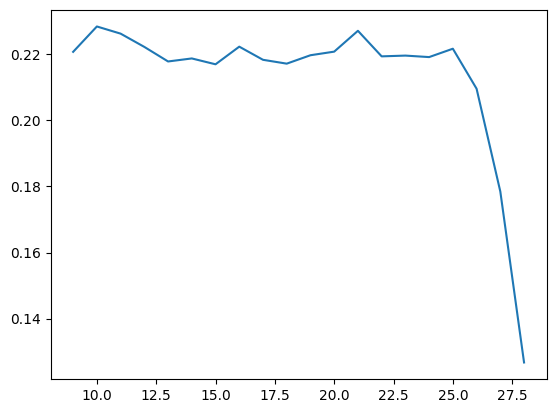

In [10]:
Y, X1, X2, x1idx, x2idx, x3idx, p_replace = genbus(alpha, N, T, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l)
plt.plot(np.arange(burnin - 1, T + burnin - 1), np.mean(p_replace[:, burnin - 1:T + burnin - 1], axis = 0))

----
## CCP Estimator

The CCP estimator makes uses the Hotz Miller result that there exists a real-valued function $\psi_k[p_t(z_t)]$ for any (potentially sub-optimal) choice $k = 1, \dots, J$ such that
$$
\psi_k[p_t(z_t)] ≡ V_t(z_t) − v_{kt}(z_t)
$$
to rewrite the choice-specific conditional value function as (for an arbitrary $k$)
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \bigg[ \psi_k[p_{t+1}(z_{t+1})] + v_{kt+1}(z_{t+1})\bigg] f_{jt}(z_{t+1} | z_{t})
$$
Now consider the sequences {[renew at $t$, renew at $t+1$]; [not renew at $t$, renew at $t+1$]}. Intuitively, because renewing tomorrow leads to the same state in the two sequences, the choice-specific conditional value functions will be the same for both sequences in all periods from $t+2$ onwards. 
To make use of this fact, use the Hotz Miller result to replace $v_{kt+1}(z_{t+1})$ in the above:
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \big[ u_{kt+1}(z_{t+1}) + \psi_k[p_{t+1}(z_{t+1})] \big] f_{jt}(z_{t+1} | z_{t}) + \beta^2 \sum_{z_{t+1}} \sum_{z_{t+2}} \big[ \psi_{k^\prime}[p_{t+2}(z_{t+2})] + v_{{k^\prime}t+2}(z_{t+2}) \big] f_{jt+1}(z_{t+2} | z_{t+1}) f_{jt}(z_{t+1} | z_{t})
$$
The difference between any two paths that lead to taking the renewal action $k$ at $t+1$ is therefore 
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) - u_{j^\prime t}(z_t) + \beta \sum_{z_{t+1}} \big[ u_{kt+1}(z_{t+1}) + \psi_k[p_{t+1}(z_{t+1})] \big] \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 
Notice that there is a **typo** in Equations 3.13 and 7.3 of the published version, which contain $- \psi_k$ instead of $+ \psi_k$. The correct formula appears in follow-up Arcidiacono Miller papers and [Llull's notes](https://joanllull.github.io/Structural_micro/Structural_micro_4.pdf) (see e.g. equation 15).

Let $j$ = not replace, $j^\prime$ = replace, and $k$ = replace. Then 
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \psi_{j^\prime}[p_{t+1}(z_{t+1})] \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 

The columns used in the "flexible logits" below. We reshape Y from $Y[n, t]$ into a column vector that iterates primarily over $n$ and secondarily over $t$.

Note here we do not observe $x3$ and we ignore its existence.

In [16]:
def logit_covariates_s(N, T, X1, X2, x3idx):

    x1_r = X1.reshape(N * T) / 10
    x2_r = np.repeat(X2, T)
    x3_r  = np.repeat(x3idx, T)
    t_r  = np.tile(np.arange(1, T + 1), N) / 10

    xx = np.empty((N * T, 6))
    xx[:, 0]  = 1
    xx[:, 1]  = x1_r
    xx[:, 2]  = x2_r
    xx[:, 3]  = x1_r * x2_r
    xx[:, 4]  = x1_r ** 2
    xx[:, 5]  = x2_r ** 2

    xx = np.column_stack([
        xx,
        np.tile( t_r, (6, 1) ).T * xx,
        np.tile( t_r ** 2, (6, 1) ).T * xx
    ])

    return xx

Columns used in the flexible logits, extrapolated to the entire state space.

In [12]:
def logit_covariates_z(t, x1, x2, x3, x1l, x2l, x3l): 
    x1r = np.tile(x1, x2l) / 10
    x2r = np.tile(x2, x1l)
    X = np.column_stack([np.ones(x2l * x1l), x1r, x2r, x1r * x2r, x1r ** 2, x2r ** 2])
    return np.column_stack([X, t / 10 * X, (t / 10) ** 2 * X])

Under the assumption that $\varepsilon \sim EVT1$, $\psi_k[p_{t+1}(z_{t+1})] = - \ln p_{kt+1}(z_{t+1})$. 

The Supp Mat contains the formula for $\psi_k()$ under a nested logit assumption; Fosgerau et al. (2021) show how to more generally compute $\psi_k()$.

$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) - \beta \sum_{z_{t+1}}\ln p_{j^\prime t+1}(z_{t+1}) \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 

In [13]:
def fvdata(b1, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran):

    # Compute - ln[p_{1t+1}(x_{t+1}, s)] using estimated logit, which has Y = 1{Renew}
    psi_renew = np.zeros((x1l * x2l, 2, T+1))
    for t in range(1, T):
        for x3i in range(x3l):  # s = 0,1
            psi_renew[:, x3i, t] = - np.log1p(np.exp(- logit_covariates_z(t, x1, x2, x3[x3i], x1l, x2l, x3l) @ b1))

    # Compute \sum_s ln[p_{1t+1}(x_{t+1}, s)] [f_2(x_{t+1}|x_t) − f_1(x_{t+1}|x_t)] -- see Supp. Mat., p.12 
    FVT1 = np.zeros((N, T))
    for n in range(N):
        for t in range(T):
            FVT1[n, t] = np.dot(psi_renew[x1l * x2idx[n] : x1l * (x2idx[n] + 1), x3idx[n], t + 1],  xtran[x1l * x2idx[n] + x1idx[n, t], :] - xtran[x1l * x2idx[n], :])

    return FVT1.reshape(N * T, 1)

---- 

## Simulation and Estimation

In [14]:
Y, X1, X2, x1idx, x2idx, x3idx, p_replace = genbus(alpha, N, T, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l)

In [17]:
yy = Y.reshape(N * T, )
xx = logit_covariates_s(N, T, X1, X2, x3idx)

logit_result = sm.Logit(yy, xx).fit()
logit_pars = logit_result.params

Optimization terminated successfully.
         Current function value: 0.445542
         Iterations 6


Since we are assuming $Y = 1 \leftrightarrow Replace$, we negate the terms in the flow utility from not replacing. 

In [22]:
RHS_7_3 = np.column_stack([ - np.ones(N * T), - X1.reshape(N * T), fvdata(logit_pars, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)])

ccp_result = sm.Logit(yy, RHS_7_3).fit()
ccp_pars = ccp_result.params

print(f"CCP Optimized parameters: {np.round(ccp_pars, 3)}. True parameters: {alpha[np.r_[0:2, 3]]}")

Optimization terminated successfully.
         Current function value: 0.444884
         Iterations 6
CCP Optimized parameters: [ 2.459 -0.148  0.839]. True parameters: [ 2.   -0.15  0.9 ]


C:\Users\forte\AppData\Local\Temp\ipykernel_14740\3816645293.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = YYhat.groupby("bin").agg({"Y": "mean", "Predicted": "mean"}).reset_index()


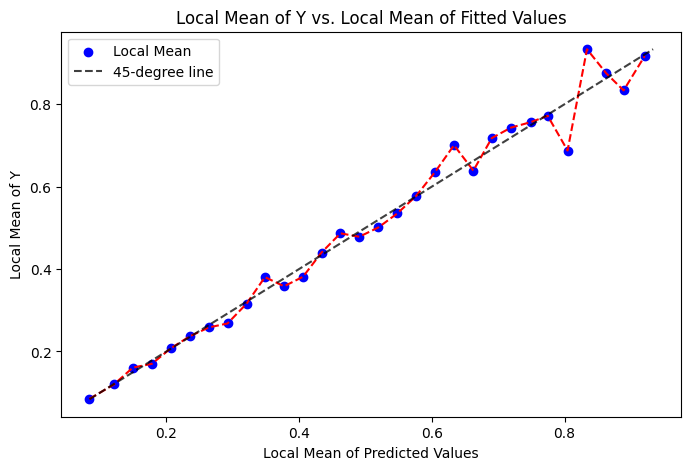

In [23]:
YYhat = pd.DataFrame( { "Y": yy, "Predicted": 1 / ( 1 + np.exp( - ccp_result.fittedvalues ) ) })

num_bins = 30
YYhat["bin"] = pd.cut(YYhat["Predicted"], bins=num_bins)
grouped = YYhat.groupby("bin").agg({"Y": "mean", "Predicted": "mean"}).reset_index()

plt.figure(figsize=(8, 5))
plt.scatter(grouped["Predicted"], grouped["Y"], label="Local Mean", color="blue")
plt.plot(grouped["Predicted"], grouped["Y"], color="red", linestyle="--")
lims = [min(grouped["Predicted"].min(), grouped["Y"].min()), max(grouped["Predicted"].max(), grouped["Y"].max())]
plt.plot(lims, lims, 'k--', alpha=0.75, label="45-degree line")
plt.xlabel("Local Mean of Predicted Values")
plt.ylabel("Local Mean of Y")
plt.title("Local Mean of Y vs. Local Mean of Fitted Values")
plt.legend()
plt.show()

---- 

## Monte Carlo

In [24]:
# starting values for FIML and CCP
Tccp  = []
Bccp  = []

for MC in range(50):
    
   ## generating the data
   Y, X1, X2, x1idx, x2idx, x3idx, p_replace = genbus(alpha, N, T, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l)

   ## CCP estimation
   time_start = time.time()
    
   yy = Y.reshape(N * T, )
   xx = logit_covariates_s(N, T, X1, X2, x3idx)

   logit_result = sm.Logit(yy, xx).fit(disp=0)
   logit_pars = logit_result.params
   
   RHS_7_3 = np.column_stack([ - np.ones(N * T), - X1.reshape(N * T), fvdata(logit_pars, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)])

   ccp_result = sm.Logit(yy, RHS_7_3).fit(disp=0)
   ccp_pars = ccp_result.params
   time_taken = time.time() - time_start
   Tccp.append(time_taken)
   Bccp.append(ccp_pars)
   print(f"CCP Time taken: {np.round(time_taken, 2)} seconds. CCP Optimized parameters: {np.round(ccp_pars, 3)}. True parameters: {alpha[np.r_[0:2, 3]]}")

CCP Time taken: 0.42 seconds. CCP Optimized parameters: [ 2.407 -0.136  0.887]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.47 seconds. CCP Optimized parameters: [ 2.429 -0.134  0.899]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.48 seconds. CCP Optimized parameters: [ 2.415 -0.141  0.866]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.43 seconds. CCP Optimized parameters: [ 2.454 -0.128  0.928]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.45 seconds. CCP Optimized parameters: [ 2.387 -0.138  0.851]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.47 seconds. CCP Optimized parameters: [ 2.41  -0.129  0.901]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.45 seconds. CCP Optimized parameters: [ 2.447 -0.127  0.947]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.42 seconds. CCP Optimized parameters: [ 2.458 -0.136  0.909]. True parameters: [ 2.   -0.15  0.9 ]
CCP Time taken: 0.48 seconds. CCP Optimized parameters: [ 2.386 

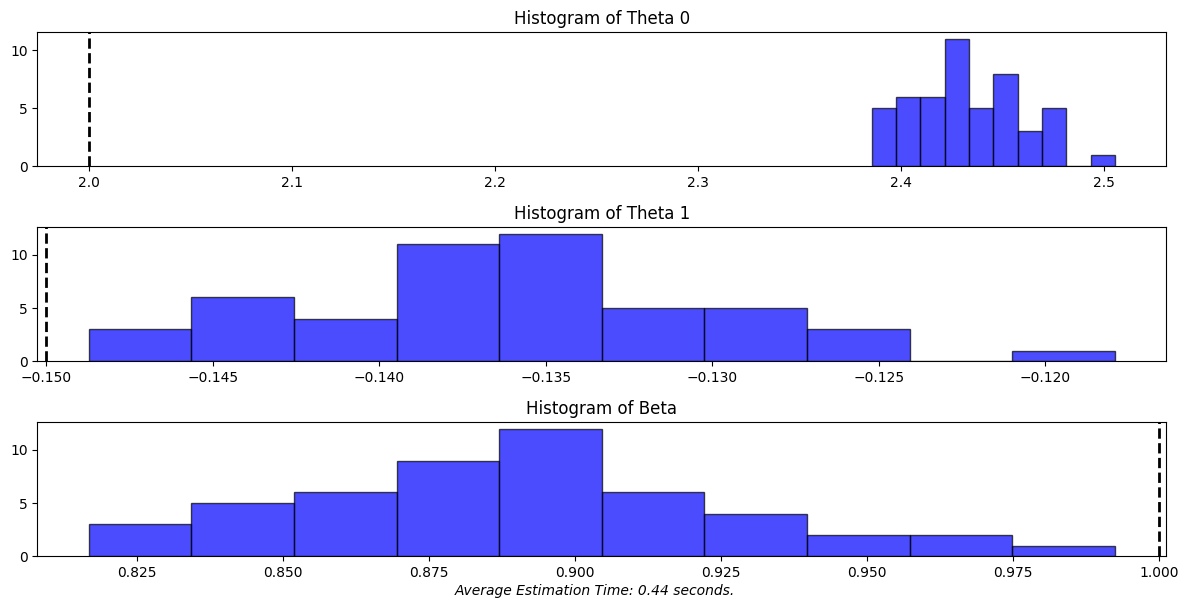

In [26]:
Bccp_df = pd.DataFrame(Bccp)
Bccp_df.columns = ["Theta 0", "Theta 1", "Beta"]
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
axes = axes.flatten()
for i, col in enumerate(Bccp_df.columns):
    axes[i].hist(Bccp_df[col], bins=10, alpha=0.7, color='b', edgecolor='black')
    axes[i].axvline(alpha[i], color='black', linestyle='dashed', linewidth=2)
    axes[i].set_title(f'Histogram of {col}')

plt.figtext(0.5, 0, f"Average Estimation Time: {np.round(np.mean(Tccp), 2)} seconds.", 
            ha="center", fontsize=10, style="italic")

# Adjust layout
plt.tight_layout()
plt.show()

----
## FIML Estimator 

Let $Y_{ijt} = j$ if the agent chooses action $j$. Then the conditional likelihood for a given observation is 
$$
Pr(Y_{it} = j | X_{it}, s_i; \theta) = 
\frac{\exp( v_{jt}(z_t) )}{\sum_{j^\prime} \exp( v_{j^\prime t}(z_t) )} = 
\frac{\exp( u_{jt}(z_t) + \beta \sum_{z_{t+1}} V_{t+1}(z_{t+1}) f_{jt}(z_{t+1} | z_{t}) )}{\sum_{j^\prime} \exp( u_{j^\prime t}(z_t) + \beta \sum_{z_{t+1}} V_{t+1}(z_{t+1}) f_{j^\prime t}(z_{t+1} | z_{t}))} = 
\frac{1}{1 + \sum_{j^\prime \neq j} e^{u_{j^\prime t}(z_t) - u_{j t}(z_t) + \beta \sum_{z_{t+1}} V_{t+1}(z_{t+1}) [ f_{j^\prime t}(z_{t+1} | z_{t}) - f_{j t}(z_{t+1} | z_{t}) ]}}
$$
cf. Supp. Mat p. 11, which uses $u_{0t}(z_t) = 0$ leading to
$$
\ln Pr(renew | X_{it}, s_i; \theta) = 
- \ln \bigg( 1 + \exp \big( u^{norenew}_{t}(z_t) + \beta \sum_{z_{t+1}} V_{t+1}(z_{t+1}) [ f^{norenew}_{t}(z_{t+1} | z_{t}) - f^{renew}_{t}(z_{t+1} | z_{t}) ] \big) \bigg)
$$
Note we store the negative log-likelihood. 

In [ ]:
def llFIML(alpha, N, T, Y, X1, X2, x1idx, x2idx, x3idx, xtran, x1, x2, x3, x1l, x2l, x3l):
    alpha[3] = np.exp(alpha[3]) / (1 + np.exp(alpha[3]))
    V = BackwardInduction_V_wrong(alpha, x1, x2, x1l, x2l, T+1)
    ll = 0
    for n in range(N):
        for t in range(T):
            v_replace   = conditional_value_function(alpha[3], flowpayoff_replace_wrong(alpha, X1[n, t], x3idx[n]), V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l, :])
            v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace_wrong(alpha, X1[n, t], x3idx[n]), V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l + x1idx[n, t], :])
            ll += np.log1p(np.exp(v_noreplace - v_replace)) - (1 - Y[n, t]) * (v_noreplace - v_replace)
    return ll

In [ ]:
# ofiml = {'method': "BFGS", 'tol': 1e-7, 'options': {'disp': False, 'maxiter': 1000}}

# alpha_fiml = alpha[np.r_[0:2, 3]]

# Tfiml = []
# Bfiml = []

# for MC in range(50):
    
#     ## generating the data
#     Y, X1, X2, x1idx, x2idx, x3idx = genbus(alpha, N, T, 10, xtran, xtranc, x1, x2, x1l, x2l)
    
#     ## FIML estimation
#     time_start = time.time()
#     fiml_result = opt.minimize(llFIML, alpha_fiml, args = (N, T, Y, X1, X2, x1idx, x2idx, x3idx, xtran, x1, x2, x1l, x2l), **ofiml)
#     fiml_pars = fiml_result.x
#     fiml_pars[3] = np.exp(fiml_pars[3]) / (1 + np.exp(fiml_pars[3]))
#     time_taken = time.time() - time_start
#     Tfiml.append(time_taken)
#     Bfiml.append(fiml_pars)
#     print(f"FIML Time taken: {round(time_taken, 2)} seconds")
#     print(f"FIML Optimized parameters: {fiml_pars}. True parameters: {alpha[:4]}. Iterations: {fiml_result.nit}")